In [5]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy


In [7]:
!nvidia-smi

Mon Apr  1 13:59:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   36C    P8              16W / 250W |    250MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [20]:
env_id = "CartPole-v1"
# env = make_vec_env(env_id, n_envs=1)
# read /mnt/nfs/work/c98181/RL/dataset/CartPole-v1...npy
observations= np.load("/mnt/nfs/work/c98181/RL/dataset/CartPole-v1_1M_obs.npy", allow_pickle=True)
actions = np.load("/mnt/nfs/work/c98181/RL/dataset/CartPole-v1_1M_actions.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape)
print(observations[0], actions[0])

# print(actions)

(1000000, 4) (1000000,)
[-0.03013654  0.21001437 -0.04612853 -0.34675622] 1


In [10]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [ ]:
policy_network = PolicyNetwork(
    4, 2).to(device)

prev = PolicyNetwork(
    4, 2).to(device)


optimizer = torch.optim.Adam(policy_network.parameters(), lr=(1e-3))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)


# Training loop
num_epochs = 300
batch_size = 512

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

graph=[]
eval_rewards=[]
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    loss_record=[]
    # step=0
    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)
        if step % 100 == 0:
          prev.load_state_dict(policy_network.state_dict())
          prev.eval()
        # Get the log probabilities of the actions
        
        softmax = policy_network(obs_batch)
        # print(softmax.shape, act_batch.shape)
        model_act_sample = Categorical(softmax).sample()
        policy_chosen_logps = Categorical(softmax).log_prob(act_batch)
        policy_rejected_logps = Categorical(softmax).log_prob(model_act_sample)
        with torch.no_grad():
            reference_chosen_logps = Categorical(prev(obs_batch)).log_prob(act_batch)
            reference_rejected_logps = Categorical(prev(obs_batch)).log_prob(model_act_sample)
          

        pi_logratios = policy_chosen_logps - policy_rejected_logps
        ref_logratios = reference_chosen_logps - reference_rejected_logps

        # chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
        # reject_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

        logits = pi_logratios - ref_logratios

        chosen_logratios = policy_chosen_logps - reference_chosen_logps
        reject_logratios = policy_rejected_logps - reference_rejected_logps

        # logits = chosen_logratios - reject_logratios

        if epoch <= 10:
          loss = - (policy_chosen_logps).mean()
        else:
          beta = 1
          losses = (
                  -F.logsigmoid(beta * logits)
              )
          # loss = losses.mean()
        #   losses = torch.cat((1 - F.logsigmoid(beta * (chosen_logratios - reject_KL)), 1 - F.logsigmoid(beta * (chosen_KL - reject_logratios))), 0)
          loss = losses.mean()
        # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = chosen_logratios.detach().mean().item()
        negative_reward = reject_logratios.detach().mean().item()
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward})


        #scheduler

        loss_record.append(loss.detach().item())
    scheduler.step()
    graph.append(sum(loss_record)/len(loss_record))

    policy_network.eval()  # 切换到评估模式

    env = make_vec_env(env_id, n_envs=1)

    state = env.reset()
    done = False
    total_reward=0
    # test the policy and save as gif
    frames = []
    while not done:
        state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
        with torch.no_grad():
            action = Categorical(policy_network(state_tensor)).sample().cpu().numpy()[0]
            
        state, reward, done, _ = env.step(action)  # 执行动作
        total_reward += reward
        frame = env.render(mode="rgb_array")  # 获取当前环境的图像
        frames.append(frame)  # 添加到帧列表中

    # 保存为GIF
    image_path = f"cartpole_epoch_{epoch+1}.gif"
    imageio.mimsave("/mnt/nfs/work/c98181/RL/result/"+env_id+"/"+image_path, frames, duration=0.04)  # duration控制帧切换的速度


    env.close()
    print(total_reward)
    eval_rewards.append(total_reward)

In [ ]:
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.title("Reward vs Epoch")
plt.show()



In [25]:
policy_network = PolicyNetwork(
    4, 2).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)
torch.nn.init.kaiming_normal_(policy_network.fc3.weight)

# build training set and validation set
train_size = int(0.9 * len(observations))
train_observations = observations[:train_size]
train_actions = actions[:train_size]
val_observations = observations[train_size:]
val_actions = actions[train_size:]

# build dataset
train_dataset = CustomDataset(train_observations, train_actions)
val_dataset = CustomDataset(val_observations, val_actions)


optimizer = torch.optim.Adam(policy_network.parameters(), lr=(1e-3),weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)


# Training loop
num_epochs = 100
batch_size = 256

train_dataloader = DataLoader(train_dataset , batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset , batch_size=batch_size, shuffle=True)

graph=[]
val_losses=[]
eval_rewards=[]
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(train_dataloader,position=0,leave=True)
    loss_record=[]

    for step, (obs_batch,act_batch) in enumerate(pbar):

        
        softmax = policy_network(obs_batch)
        # cross entropy
        loss = F.cross_entropy(softmax, act_batch.long())
        
        # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        pbar.set_postfix({"loss":loss.detach().item()})


        #scheduler

        loss_record.append(loss.detach().item())
    scheduler.step()
    graph.append(sum(loss_record)/len(loss_record))
    with torch.no_grad():
        # validation_loss
        val_loss_record=[]
        for step, (obs_batch,act_batch) in enumerate(val_dataloader):
            softmax = policy_network(obs_batch)
            loss = F.cross_entropy(softmax, act_batch.long())
            val_loss_record.append(loss.detach().item())
        val_loss = sum(val_loss_record)/len(val_loss_record)
        val_losses.append(val_loss)
    
    prev.load_state_dict(policy_network.state_dict())
    prev.eval()
    
    policy_network.eval()  # 切换到评估模式

    env = make_vec_env(env_id, n_envs=1)
    # test ten times
    total_reward=0
    for _ in range(10):
        state = env.reset()
        done = False
        
        # test the policy and save as gif
        frames = []
        while not done:
            state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
            with torch.no_grad():
                pred= policy_network(state_tensor)
                action = torch.argmax(pred).cpu().numpy()
                # print(action)
                
            state, reward, done, _ = env.step([action])  # 执行动作
            total_reward += reward
            frame = env.render(mode="rgb_array")  # 获取当前环境的图像
            frames.append(frame)  # 添加到帧列表中

    # 保存为GIF
    image_path = f"cartpole_epoch_{epoch+1}.gif"
    imageio.mimsave("/mnt/nfs/work/c98181/RL/result/"+env_id+"/"+image_path, frames, duration=0.04)  # duration控制帧切换的速度


    env.close()
    print(total_reward/10, val_loss)
    
    eval_rewards.append(total_reward/10)


  0%|          | 0/3516 [00:00<?, ?it/s]

Epoch [1/100]: 100%|██████████| 3516/3516 [00:12<00:00, 282.16it/s, loss=0.168] 


[13.7] 0.13943648507909093


Epoch [2/100]: 100%|██████████| 3516/3516 [00:12<00:00, 285.29it/s, loss=0.0817]


[16.8] 0.13830819621186732


Epoch [3/100]: 100%|██████████| 3516/3516 [00:12<00:00, 285.74it/s, loss=0.105] 


[17.6] 0.12372840152067296


Epoch [4/100]: 100%|██████████| 3516/3516 [00:12<00:00, 286.06it/s, loss=0.0742]


[19.7] 0.12993303402458006


Epoch [5/100]: 100%|██████████| 3516/3516 [00:12<00:00, 286.48it/s, loss=0.11]  


[15.] 0.11837364799912324


Epoch [6/100]: 100%|██████████| 3516/3516 [00:12<00:00, 286.36it/s, loss=0.119] 


[13.] 0.11437152160326843


Epoch [7/100]: 100%|██████████| 3516/3516 [00:12<00:00, 286.85it/s, loss=0.102] 


[11.6] 0.11607101721608121


Epoch [8/100]: 100%|██████████| 3516/3516 [00:12<00:00, 275.22it/s, loss=0.0859]


[17.4] 0.1140247601110612


Epoch [9/100]: 100%|██████████| 3516/3516 [00:12<00:00, 285.67it/s, loss=0.142] 


[15.7] 0.11111239742135148


Epoch [10/100]: 100%|██████████| 3516/3516 [00:12<00:00, 287.53it/s, loss=0.0925]


[20.1] 0.11201082049961895


Epoch [11/100]: 100%|██████████| 3516/3516 [00:12<00:00, 286.52it/s, loss=0.0836]


[14.6] 0.10939817584079245


Epoch [12/100]: 100%|██████████| 3516/3516 [00:12<00:00, 284.15it/s, loss=0.0697]


[15.6] 0.10897243249675502


Epoch [13/100]: 100%|██████████| 3516/3516 [00:12<00:00, 286.13it/s, loss=0.0688]


[11.6] 0.11037507799961378


Epoch [14/100]: 100%|██████████| 3516/3516 [00:12<00:00, 286.62it/s, loss=0.108] 


[13.3] 0.11004109964575


Epoch [15/100]: 100%|██████████| 3516/3516 [00:12<00:00, 287.21it/s, loss=0.142] 


[16.6] 0.11427595937038626


Epoch [16/100]: 100%|██████████| 3516/3516 [00:12<00:00, 286.39it/s, loss=0.131] 


[11.3] 0.10846872424797328


Epoch [17/100]: 100%|██████████| 3516/3516 [00:12<00:00, 286.84it/s, loss=0.143] 


[11.7] 0.11411748077634655


Epoch [18/100]: 100%|██████████| 3516/3516 [00:12<00:00, 285.77it/s, loss=0.125] 


[12.1] 0.10843194770576704


Epoch [19/100]: 100%|██████████| 3516/3516 [00:12<00:00, 283.81it/s, loss=0.14]  


[13.9] 0.10682555955008168


Epoch [20/100]: 100%|██████████| 3516/3516 [00:12<00:00, 284.86it/s, loss=0.106] 


[17.7] 0.11062083475272674


Epoch [21/100]: 100%|██████████| 3516/3516 [00:12<00:00, 281.13it/s, loss=0.149] 


[17.9] 0.10596149482423692


Epoch [22/100]:   0%|          | 0/3516 [00:00<?, ?it/s, loss=0.107] 

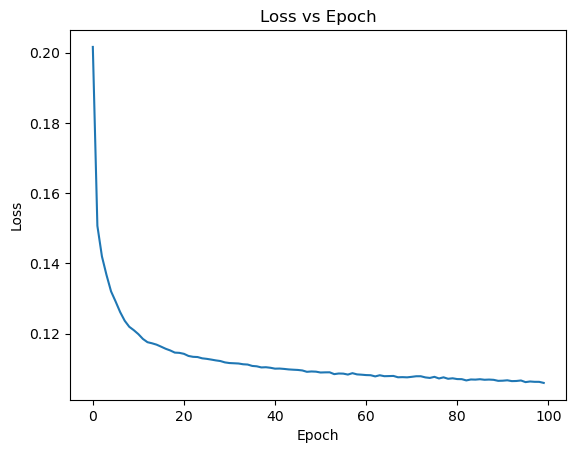

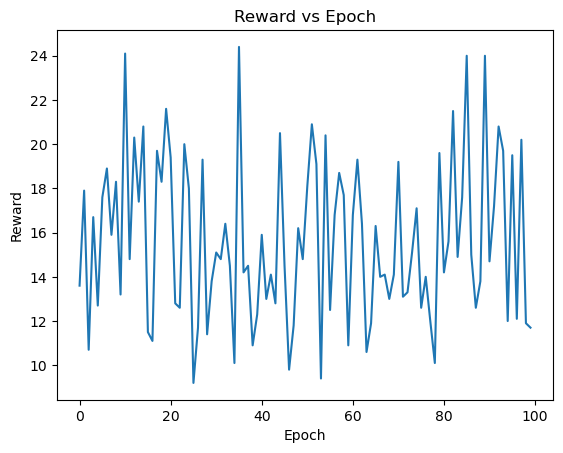

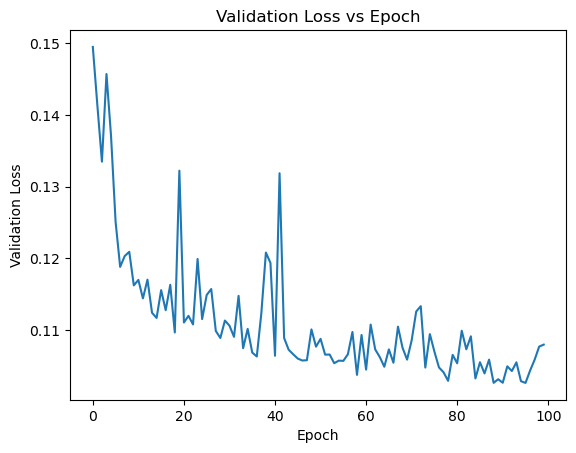

In [23]:
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.title("Reward vs Epoch")
plt.show()
# draw the validation loss graph
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epoch")
plt.show()

